In [1]:
from langdetect import detect, LangDetectException
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import chardet
import nltk
import re
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
arxiv_df = pd.read_csv("_data/3_arXiv_Dataset/arxiv_preprocessed.csv")
print("\n--- Basic Dataset Information ---")
print(arxiv_df.info())
print("\nSample data:")
arxiv_df.head()


--- Basic Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680885 entries, 0 to 2680884
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   abstract            object
 1   update_date         object
 2   processed_abstract  object
 3   merged_category     object
dtypes: object(4)
memory usage: 81.8+ MB
None

Sample data:


,abstract,update_date,processed_abstract,merged_category
0,A fully differential calculation in perturba...,2008-11-26,fully differential calculation perturbative qu...,High Energy Physics
1,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13,describe new algorithm game color use obtain c...,Mathematics
2,The evolution of Earth-Moon system is descri...,2008-01-13,evolution system described dark matter field f...,Physics
3,We show that a determinant of Stirling cycle...,2007-05-23,show determinant stirling cycle number count u...,Mathematics
4,In this paper we show how to compute the $\L...,2013-10-15,paper show compute norm 0 using dyadic grid re...,Mathematics


# 1. Dataset dimensions: Number of documents, class counts, and proportions 

In [3]:
text_field = 'processed_abstract'
category_field = 'merged_category'

1. DATASET DIMENSIONS
Total number of documents: 2,680,885
Number of features: 4

Class counts and proportions:
                                    Count  Percentage
merged_category                                      
Computer Science                   598894   22.339414
Physics                            534499   19.937409
Mathematics                        526484   19.638440
Astrophysics & Cosmology           378833   14.130893
High Energy Physics                285961   10.666664
Quantum Physics                    115832    4.320663
Statistics & Mathematical Physics   85776    3.199540
Engineering & Systems               57767    2.154774
Nuclear Physics                     45872    1.711077
Life Sciences                       30425    1.134886
Economics & Finance                 20542    0.766240


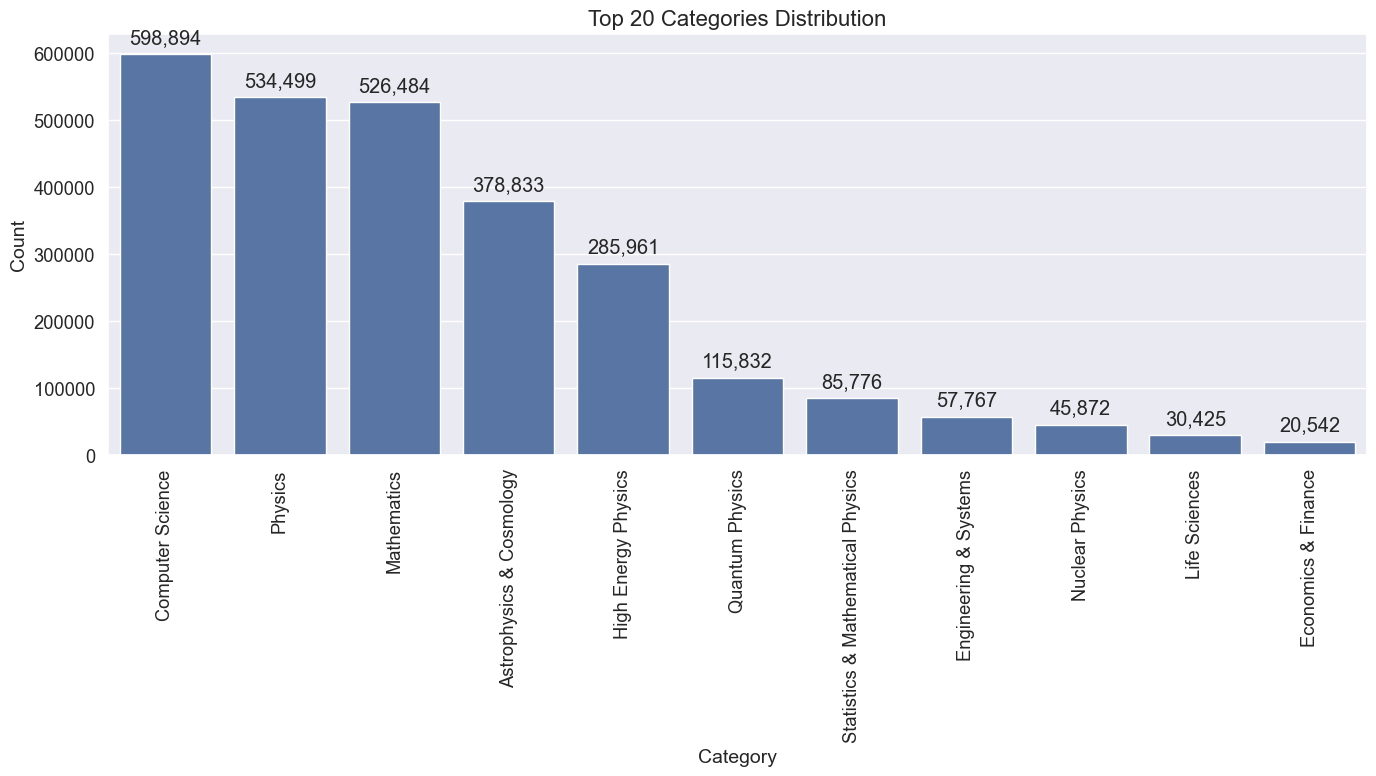

In [4]:
print("="*80)
print("1. DATASET DIMENSIONS")
print("="*80)

print(f"Total number of documents: {arxiv_df.shape[0]:,}")
print(f"Number of features: {arxiv_df.shape[1]}")

print("\nClass counts and proportions:")
class_counts = arxiv_df[category_field].value_counts()
class_proportions = 100 * class_counts / len(arxiv_df)

# Combine counts and proportions in a dataframe for better visualization
class_stats = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_proportions
})
print(class_stats)

# Visualize class distribution
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=class_counts.index[:20], y=class_counts.values[:20])
plt.title('Top 20 Categories Distribution', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)

# Add count labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()


# 2. Data completeness: Missing values analysis in both text and labels

In [5]:
print("\n" + "="*80)
print("2. DATA COMPLETENESS")
print("="*80)

# Check for missing values
missing_values = arxiv_df.isnull().sum()
missing_percentage = 100 * missing_values / len(arxiv_df)

# Combine counts and percentages in a dataframe
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_stats)

# Check for empty strings or whitespace-only values
empty_strings = {}
for col in arxiv_df.columns:
    if arxiv_df[col].dtype == 'object':
        empty_strings[col] = ((arxiv_df[col] == '') | (arxiv_df[col].str.isspace()) | (arxiv_df[col].str.len() == 0)).sum()

print("\nEmpty strings or whitespace-only values:")
for col, count in empty_strings.items():
    print(f"{col}: {count} ({100 * count / len(arxiv_df):.2f}%)")


2. DATA COMPLETENESS
                    Missing Values  Percentage
abstract                         0    0.000000
update_date                      0    0.000000
processed_abstract              18    0.000671
merged_category                  0    0.000000

Empty strings or whitespace-only values:
abstract: 0 (0.00%)
update_date: 0 (0.00%)
processed_abstract: 0 (0.00%)
merged_category: 0 (0.00%)


# 3. Text length statistics: Min/max/avg token/character counts per sample


3. TEXT LENGTH STATISTICS

Abstract Character Length:
  Min: 6.00
  Max: 6,091.00
  Mean: 970.79
  Median: 943.00
  Std Dev: 430.75

Abstract Word Count:
  Min: 1.00
  Max: 925.00
  Mean: 142.67
  Median: 138.00
  Std Dev: 63.42

Processed Abstract Character Length:
  Min: 3.00
  Max: 4,202.00
  Mean: 652.60
  Median: 631.00
  Std Dev: 303.07

Processed Abstract Word Count:
  Min: 1.00
  Max: 521.00
  Mean: 81.04
  Median: 78.00
  Std Dev: 37.64


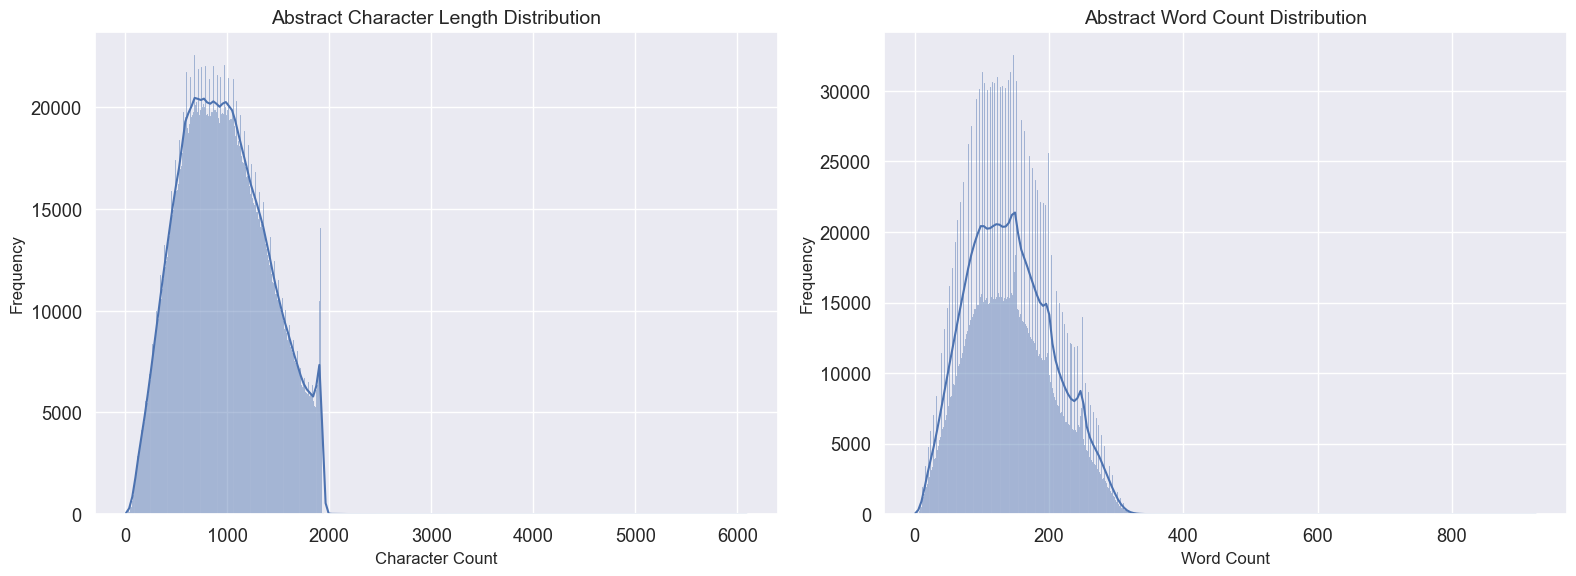

In [6]:
print("\n" + "="*80)
print("3. TEXT LENGTH STATISTICS")
print("="*80)

# Function to calculate text statistics
def text_stats(series, name):
    char_lengths = series.str.len()
    word_lengths = series.str.split().str.len()

    stats = {
        f"{name} Character Length": {
            "Min": char_lengths.min(),
            "Max": char_lengths.max(),
            "Mean": char_lengths.mean(),
            "Median": char_lengths.median(),
            "Std Dev": char_lengths.std()
        },
        f"{name} Word Count": {
            "Min": word_lengths.min(),
            "Max": word_lengths.max(),
            "Mean": word_lengths.mean(),
            "Median": word_lengths.median(),
            "Std Dev": word_lengths.std()
        }
    }
    return stats

# Get statistics for abstracts and processed abstracts
abstract_stats = text_stats(arxiv_df['abstract'], "Abstract")
processed_abstract_stats = text_stats(arxiv_df[text_field], "Processed Abstract")

# Print statistics
for name, stats_dict in {**abstract_stats, **processed_abstract_stats}.items():
    print(f"\n{name}:")
    for stat, value in stats_dict.items():
        print(f"  {stat}: {value:,.2f}")

# Visualize text length distributions
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(arxiv_df['abstract'].str.len(), kde=True)
plt.title('Abstract Character Length Distribution', fontsize=14)
plt.xlabel('Character Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(arxiv_df['abstract'].str.split().str.len(), kde=True)
plt.title('Abstract Word Count Distribution', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# 4. Character encoding: Identification of non-standard or problematic encodings

In [7]:
print("\n" + "="*80)
print("4. CHARACTER ENCODING ANALYSIS")
print("="*80)

# Sample a subset of abstracts to check for encoding issues
sample_size = min(1000, len(arxiv_df))  # Limit sample size for performance
sample_abstracts = arxiv_df['abstract'].sample(sample_size).values

# Function to detect encoding and problematic characters
def detect_encoding_issues(text_sample):
    # Detect encoding
    detection = chardet.detect(text_sample.encode())

    # Check for non-ASCII characters
    non_ascii = re.findall(r'[^\x00-\x7F]', text_sample)

    return {
        'detected_encoding': detection['encoding'],
        'confidence': detection['confidence'],
        'non_ascii_chars': set(non_ascii) if non_ascii else set(),
        'non_ascii_count': len(non_ascii)
    }

encoding_results = [detect_encoding_issues(text) for text in sample_abstracts if isinstance(text, str)]

# Summarize encoding results
encoding_counts = Counter([result['detected_encoding'] for result in encoding_results])
print("Detected encodings in sample:")
for encoding, count in encoding_counts.items():
    print(f"  {encoding}: {count} ({100 * count / len(encoding_results):.2f}%)")

# Identify common non-ASCII characters
all_non_ascii = set()
for result in encoding_results:
    all_non_ascii.update(result['non_ascii_chars'])

if all_non_ascii:
    print("\nCommon non-ASCII characters found in sample:")
    for char in list(all_non_ascii)[:20]:  # Show up to 20 characters
        print(f"  '{char}' (Unicode: {ord(char)})")

    if len(all_non_ascii) > 20:
        print(f"  ... and {len(all_non_ascii) - 20} more")
else:
    print("\nNo non-ASCII characters found in sample.")


4. CHARACTER ENCODING ANALYSIS
Detected encodings in sample:
  ascii: 999 (99.90%)
  None: 1 (0.10%)

No non-ASCII characters found in sample.


# 5. Class balance assessment: Distribution visualization and imbalance quantification


5. CLASS BALANCE ASSESSMENT
Number of unique classes: 11
Majority class: Computer Science with 598,894 instances (22.34%)
Minority class: Economics & Finance with 20,542 instances (0.77%)
Imbalance ratio (majority:minority): 29.15
Gini coefficient: 0.4878 (0=perfect balance, 1=perfect imbalance)
Shannon entropy: 2.8530 bits
Maximum possible entropy: 3.4594 bits
Normalized entropy: 0.8247 (1=perfect balance, 0=perfect imbalance)


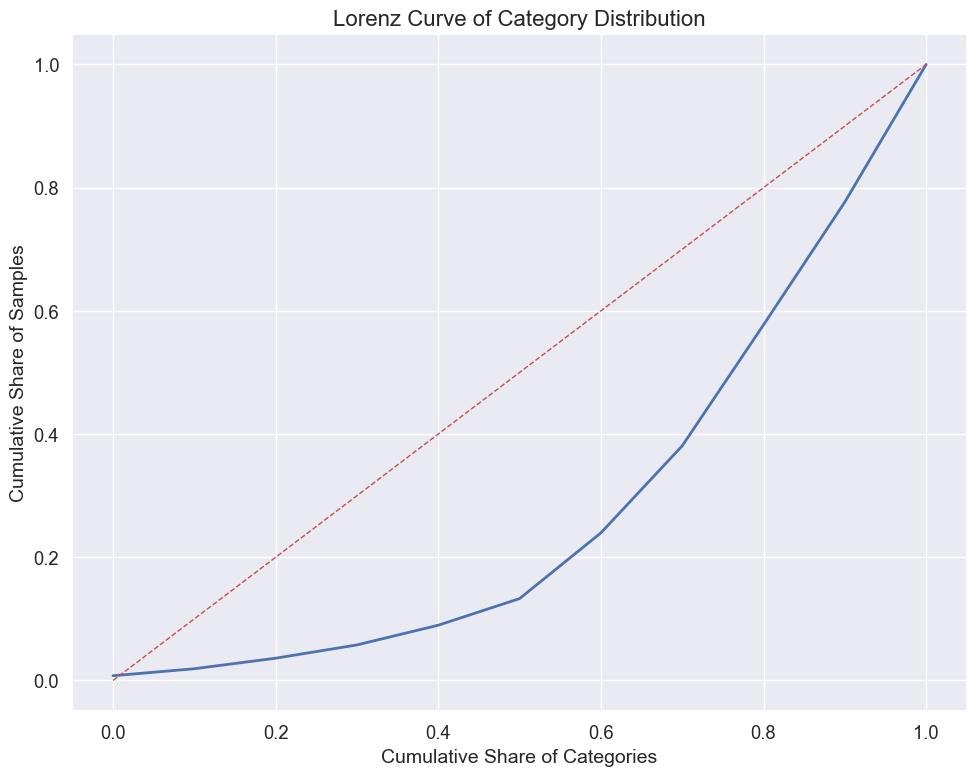

In [8]:
print("\n" + "="*80)
print("5. CLASS BALANCE ASSESSMENT")
print("="*80)

# Calculate class imbalance metrics
num_classes = len(class_counts)
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Number of unique classes: {num_classes}")
print(f"Majority class: {majority_class} with {class_counts.max():,} instances ({class_proportions.max():.2f}%)")
print(f"Minority class: {minority_class} with {class_counts.min():,} instances ({class_proportions.min():.2f}%)")
print(f"Imbalance ratio (majority:minority): {imbalance_ratio:.2f}")

# Gini coefficient as a measure of imbalance
def gini_coefficient(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    return 0.5 * rmad

gini = gini_coefficient(class_counts.values)
print(f"Gini coefficient: {gini:.4f} (0=perfect balance, 1=perfect imbalance)")

# Shannon entropy as a measure of diversity
def shannon_entropy(x):
    x = x / x.sum()  # Normalize to probabilities
    return -np.sum(x * np.log2(x))

entropy = shannon_entropy(class_counts.values)
max_entropy = np.log2(num_classes)  # Maximum possible entropy
normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
print(f"Shannon entropy: {entropy:.4f} bits")
print(f"Maximum possible entropy: {max_entropy:.4f} bits")
print(f"Normalized entropy: {normalized_entropy:.4f} (1=perfect balance, 0=perfect imbalance)")

# Visualize class imbalance with a Lorenz curve
plt.figure(figsize=(10, 8))
class_counts_sorted = np.sort(class_counts.values)
cumulative_share = np.cumsum(class_counts_sorted) / class_counts_sorted.sum()
class_percentile = np.linspace(0, 1, len(class_counts_sorted))

plt.plot(class_percentile, cumulative_share, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', linewidth=1)  # Line of perfect equality
plt.xlabel('Cumulative Share of Categories', fontsize=14)
plt.ylabel('Cumulative Share of Samples', fontsize=14)
plt.title('Lorenz Curve of Category Distribution', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Data format verification: Checking for consistent formatting

In [9]:
print("\n" + "="*80)
print("6. DATA FORMAT VERIFICATION")
print("="*80)

# Check update_date format consistency
date_patterns = {
    'YYYY-MM-DD': r'^\d{4}-\d{2}-\d{2}$',
    'Other format': r'.*'
}

date_format_counts = {}
for pattern_name, pattern in date_patterns.items():
    date_format_counts[pattern_name] = arxiv_df['update_date'].str.match(pattern).sum()

print("Date format distribution:")
for format_name, count in date_format_counts.items():
    print(f"  {format_name}: {count} ({100 * count / len(arxiv_df):.2f}%)")

# Check processed_abstract format consistency
# Look for patterns that might indicate inconsistent processing
processed_abstract_patterns = {
    'Contains HTML': r'<.*?>',
    'Contains LaTeX': r'\\[a-zA-Z]+',
    'Contains URLs': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    'Contains special chars': r'[^a-zA-Z0-9\s]'
}

processed_pattern_counts = {}
sample_size = min(10000, len(arxiv_df))  # Limit sample size for performance
sample_processed = arxiv_df[text_field].sample(sample_size)

for pattern_name, pattern in processed_abstract_patterns.items():
    processed_pattern_counts[pattern_name] = sample_processed.str.contains(pattern, regex=True).sum()

print("\nProcessed abstract format checks (based on sample):")
for pattern_name, count in processed_pattern_counts.items():
    print(f"  {pattern_name}: {count} ({100 * count / sample_size:.2f}%)")

# Check primary_category format consistency
cat_pattern = r'^[a-zA-Z0-9\.\-]+$'  # Basic pattern for category codes
valid_categories = arxiv_df[category_field].str.match(cat_pattern).sum()
print(f"\nCategory format consistency: {valid_categories} ({100 * valid_categories / len(arxiv_df):.2f}%) follow expected pattern")



6. DATA FORMAT VERIFICATION
Date format distribution:
  YYYY-MM-DD: 2680885 (100.00%)
  Other format: 2680885 (100.00%)

Processed abstract format checks (based on sample):
  Contains HTML: 0 (0.00%)
  Contains LaTeX: 0 (0.00%)
  Contains URLs: 0 (0.00%)
  Contains special chars: 0 (0.00%)

Category format consistency: 1060983 (39.58%) follow expected pattern


# 7. Metadata overview: Summary of all available features besides the text


7. METADATA OVERVIEW
Available metadata columns:

update_date:
  Data type: object
  Unique values: 5,334
  Most common values:
    2007-05-23: 129,080 (4.81%)
    2008-11-26: 33,169 (1.24%)
    2009-11-10: 32,166 (1.20%)
    2009-10-31: 31,152 (1.16%)
    2009-11-07: 29,250 (1.09%)

merged_category:
  Data type: object
  Unique values: 11
  Most common values:
    Computer Science: 598,894 (22.34%)
    Physics: 534,499 (19.94%)
    Mathematics: 526,484 (19.64%)
    Astrophysics & Cosmology: 378,833 (14.13%)
    High Energy Physics: 285,961 (10.67%)

Publication date analysis:
  Date range: 2007-05-23 to 2025-03-14 (6505 days)


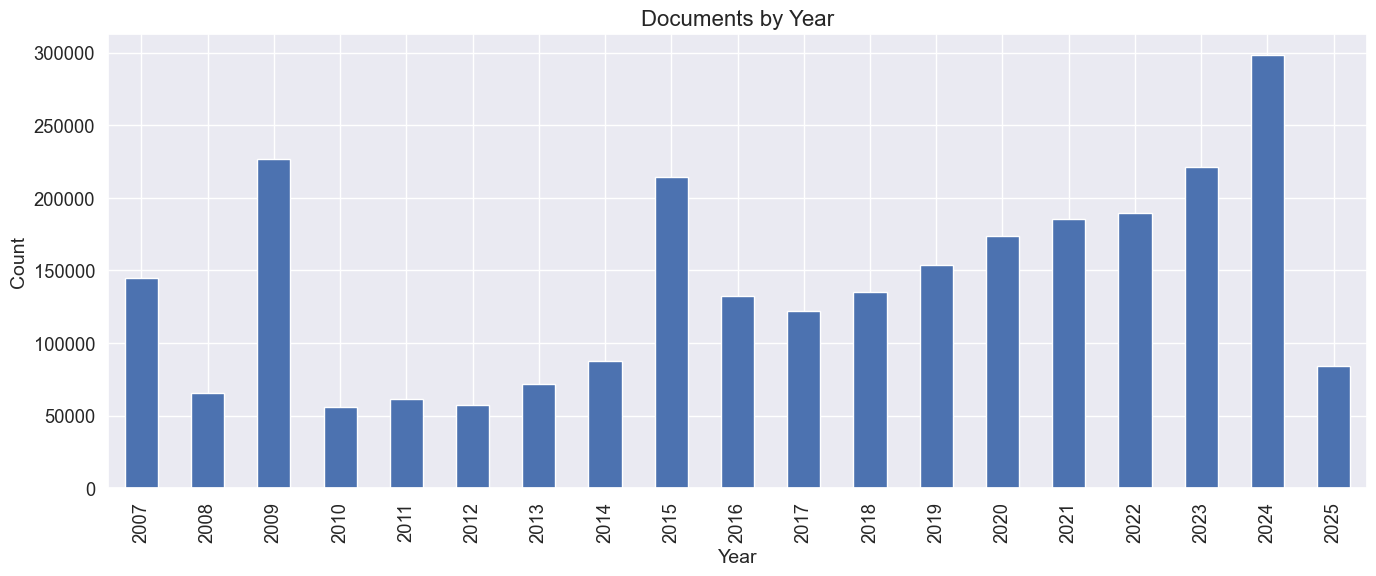

In [10]:
print("\n" + "="*80)
print("7. METADATA OVERVIEW")
print("="*80)

print("Available metadata columns:")
for col in arxiv_df.columns:
    if col not in ['abstract', text_field]:
        print(f"\n{col}:")
        # Display basic statistics based on data type
        if arxiv_df[col].dtype == 'object':
            unique_values = arxiv_df[col].nunique()
            print(f"  Data type: {arxiv_df[col].dtype}")
            print(f"  Unique values: {unique_values:,}")
            print(f"  Most common values:")
            for val, count in arxiv_df[col].value_counts().head(5).items():
                print(f"    {val}: {count:,} ({100 * count / len(arxiv_df):.2f}%)")
        else:
            print(f"  Data type: {arxiv_df[col].dtype}")
            print(f"  Min: {arxiv_df[col].min()}")
            print(f"  Max: {arxiv_df[col].max()}")
            print(f"  Mean: {arxiv_df[col].mean():.2f}")
            print(f"  Median: {arxiv_df[col].median()}")

# Analyze update_date distribution if it exists
if 'update_date' in arxiv_df.columns:
    # Convert to datetime for better analysis
    try:
        arxiv_df['update_date_dt'] = pd.to_datetime(arxiv_df['update_date'])
        date_range = arxiv_df['update_date_dt'].max() - arxiv_df['update_date_dt'].min()

        print("\nPublication date analysis:")
        print(f"  Date range: {arxiv_df['update_date_dt'].min().date()} to {arxiv_df['update_date_dt'].max().date()} ({date_range.days} days)")

        # Plot date distribution by year
        plt.figure(figsize=(14, 6))
        arxiv_df['update_date_dt'].dt.year.value_counts().sort_index().plot(kind='bar')
        plt.title('Documents by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.tight_layout()
        plt.show()
    except:
        print("\nCould not convert update_date to datetime format for analysis.")

# 8. Data source validation: Verifying origins of different text segments

In [11]:
print("\n" + "="*80)
print("8. DATA SOURCE VALIDATION")
print("="*80)

# Attempt to identify languages or sources based on content patterns
# Sample abstracts for language detection
sample_size = min(1000, len(arxiv_df))
language_sample = arxiv_df['abstract'].sample(sample_size).dropna().tolist()

# Detect languages
languages = {}
for idx, abstract in enumerate(language_sample):
    try:
        lang = detect(abstract)
        languages[lang] = languages.get(lang, 0) + 1
    except LangDetectException:
        languages['unknown'] = languages.get('unknown', 0) + 1

    # Show progress every 100 samples
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1} samples for language detection...")

print("\nDetected languages in abstract sample:")
for lang, count in sorted(languages.items(), key=lambda x: x[1], reverse=True):
    print(f"  {lang}: {count} ({100 * count / len(language_sample):.2f}%)")

# Check for patterns that might indicate different sources
source_patterns = {
    'arXiv style': r'arXiv|preprint',
    'Journal reference': r'doi:|journal|vol\.|volume',
    'Conference paper': r'conference|proceedings|symposium',
    'Technical report': r'technical report|tech\.?\s+rep'
}

source_counts = {}
for pattern_name, pattern in source_patterns.items():
    source_counts[pattern_name] = arxiv_df['abstract'].str.contains(pattern, case=False, regex=True).sum()

print("\nPossible source indicators in abstracts:")
for source, count in source_counts.items():
    print(f"  {source}: {count} ({100 * count / len(arxiv_df):.2f}%)")


8. DATA SOURCE VALIDATION
  Processed 100 samples for language detection...
  Processed 200 samples for language detection...
  Processed 300 samples for language detection...
  Processed 400 samples for language detection...
  Processed 500 samples for language detection...
  Processed 600 samples for language detection...
  Processed 700 samples for language detection...
  Processed 800 samples for language detection...
  Processed 900 samples for language detection...
  Processed 1000 samples for language detection...

Detected languages in abstract sample:
  en: 1000 (100.00%)

Possible source indicators in abstracts:
  arXiv style: 15255 (0.57%)
  Journal reference: 66988 (2.50%)
  Conference paper: 7281 (0.27%)
  Technical report: 844 (0.03%)


# 9. Quality check: Identifying duplicates, empty entries, outliers

In [12]:
print("\n" + "="*80)
print("9. QUALITY CHECK")
print("="*80)

# Find exact duplicates in abstracts
duplicate_abstracts = arxiv_df['abstract'].duplicated().sum()
print(f"Exact duplicate abstracts: {duplicate_abstracts} ({100 * duplicate_abstracts / len(arxiv_df):.2f}%)")

# Find nearly identical abstracts using a simple approach
# Convert a sample to lowercase for more accurate similarity detection
sample_size = min(10000, len(arxiv_df))
sample_lowercase = arxiv_df['abstract'].sample(sample_size).str.lower()
# Remove punctuation and extra spaces
sample_cleaned = sample_lowercase.str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True)
# Find duplicates after cleaning
cleaned_duplicates = sample_cleaned.duplicated().sum()
print(f"Near-duplicate abstracts (based on sample after cleaning): {cleaned_duplicates} ({100 * cleaned_duplicates / sample_size:.2f}%)")

# Detect outliers in text length
char_lengths = arxiv_df['abstract'].str.len()
word_lengths = arxiv_df['abstract'].str.split().str.len()

# Use the IQR method to find outliers
def find_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound) | (series > upper_bound)

char_outliers = find_outliers_iqr(char_lengths)
word_outliers = find_outliers_iqr(word_lengths)

print(f"\nOutliers in abstract character length: {char_outliers.sum()} ({100 * char_outliers.sum() / len(arxiv_df):.2f}%)")
print(f"Outliers in abstract word count: {word_outliers.sum()} ({100 * word_outliers.sum() / len(arxiv_df):.2f}%)")

# Identify short abstracts that might be problematic
very_short_abstracts = (word_lengths < 10).sum()
print(f"Very short abstracts (<10 words): {very_short_abstracts} ({100 * very_short_abstracts / len(arxiv_df):.2f}%)")

# Identify potential quality issues in processed abstracts
if text_field in arxiv_df.columns:
    processed_len = arxiv_df[text_field].str.len()
    very_short_processed = (processed_len < 10).sum()
    print(f"Very short processed abstracts (<10 chars): {very_short_processed} ({100 * very_short_processed / len(arxiv_df):.2f}%)")

    # Check for processing inconsistencies
    # Original much longer than processed could indicate over-filtering
    len_ratio = processed_len / char_lengths
    suspicious_ratio = ((len_ratio < 0.3) | (len_ratio > 2)).sum()
    print(f"Suspicious length ratios (processed/original): {suspicious_ratio} ({100 * suspicious_ratio / len(arxiv_df):.2f}%)")



9. QUALITY CHECK
Exact duplicate abstracts: 1786 (0.07%)
Near-duplicate abstracts (based on sample after cleaning): 0 (0.00%)

Outliers in abstract character length: 406 (0.02%)
Outliers in abstract word count: 791 (0.03%)
Very short abstracts (<10 words): 1524 (0.06%)
Very short processed abstracts (<10 chars): 43 (0.00%)
Suspicious length ratios (processed/original): 5150 (0.19%)


# Summary

In [13]:
print("\n" + "="*80)
print("10. DATA PROFILING SUMMARY")
print("="*80)

print(f"Dataset size: {arxiv_df.shape[0]:,} documents with {arxiv_df.shape[1]} features")
print(f"Number of categories: {num_classes}")
print(f"Missing values: {missing_values.sum()} total")
print(f"Duplicate abstracts: {duplicate_abstracts}")
print(f"Language distribution: Primarily {max(languages.items(), key=lambda x: x[1])[0]}")
print(f"Date range: {arxiv_df['update_date'].min()} to {arxiv_df['update_date'].max()}")
print(f"Average abstract length: {char_lengths.mean():.1f} characters, {word_lengths.mean():.1f} words")
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

print("\nRecommendations based on profiling:")
if missing_values.sum() > 0:
    print("- Handle missing values before analysis")
if duplicate_abstracts > 0:
    print("- Consider removing or flagging duplicate entries")
if imbalance_ratio > 10:
    print("- Address class imbalance through sampling or weighting techniques")
if very_short_abstracts > 0:
    print("- Review very short abstracts for quality issues")
if any(lang != 'en' for lang in languages if languages[lang] > 0.05 * len(language_sample)):
    print("- Consider language filtering or translation for non-English content")


10. DATA PROFILING SUMMARY
Dataset size: 2,680,885 documents with 5 features
Number of categories: 11
Missing values: 18 total
Duplicate abstracts: 1786
Language distribution: Primarily en
Date range: 2007-05-23 to 2025-03-14
Average abstract length: 970.8 characters, 142.7 words
Class imbalance ratio: 29.15

Recommendations based on profiling:
- Handle missing values before analysis
- Consider removing or flagging duplicate entries
- Address class imbalance through sampling or weighting techniques
- Review very short abstracts for quality issues
